In [1]:
import math
import torch
from torch import nn
from torch import Tensor
from torch.nn  import functional as F
import gpytorch
from matplotlib import pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.cm as cm
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D 
import sys
from decimal import Decimal
from IPython.display import clear_output
sys.path.append("..")
from LBFGS import FullBatchLBFGS
from kernels import vvkernels as vvk, sep_vvkernels as svvk, vvk_rbfkernel as vvk_rbf
from means import vvmeans as vvm
from likelihood import vvlikelihood as vvll
from mlikelihoods import MarginalLogLikelihood as exmll
from predstrategies import GPprediction
from utils import ObjFun, get_vertices, stopping_criteria
from scipy import stats
import numpy as np
import scipy.io
import seaborn as sns
import scipy
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=40)     # fontsize of the axes title
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=32)    # fontsize of the tick labels
plt.rc('ytick', labelsize=32)    # fontsize of the tick labels
plt.rc('legend', fontsize=32)    # legend fontsize
plt.rc('font', size=32)      # controls default text sizes



In [3]:
noise_value = 0.0004 #noise_free = 0.
D= 2
N=2
vf = ObjFun()
def vfield_(x):
    x = x.reshape(x.shape[0],D)
    out = torch.zeros(x.shape[0], N)
    
    out = vf(x[:,0], x[:,1]) + torch.randn(Tensor(vf(x[:,0], x[:,1])).size()) * math.sqrt(noise_value)
    return out
data= scipy.io.loadmat('data_plots/A.mat')
g_theta1 = data['A']

In [4]:

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood,num_base_kernels):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        a = torch.ones(2,2)
        chol_q = torch.tril(a)
        self.mean_module = vvm.TensorProductSubMean(gpytorch.means.LinearMean(2), num_tasks = 2)  #vvm.TensorProductSubMean(gpytorch.means.LinearMean(2), num_tasks = 2)#vvm.TensorProductSubMean(gpytorch.means.ConstantMean(), num_tasks = 2)  # 
        base_kernels = []
        for i in range(num_base_kernels):
            base_kernels.append(gpytorch.kernels.ScaleKernel(( gpytorch.kernels.RBFKernel() ))) #gpytorch.kernels.PolynomialKernel(4)  ##gpytorch.kernels.MaternKernel()# (vvk_rbf.vvkRBFKernel())
 
            
        self.covar_module = svvk.SepTensorProductKernel(base_kernels,num_tasks = 2)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [5]:
import matplotlib.ticker
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format

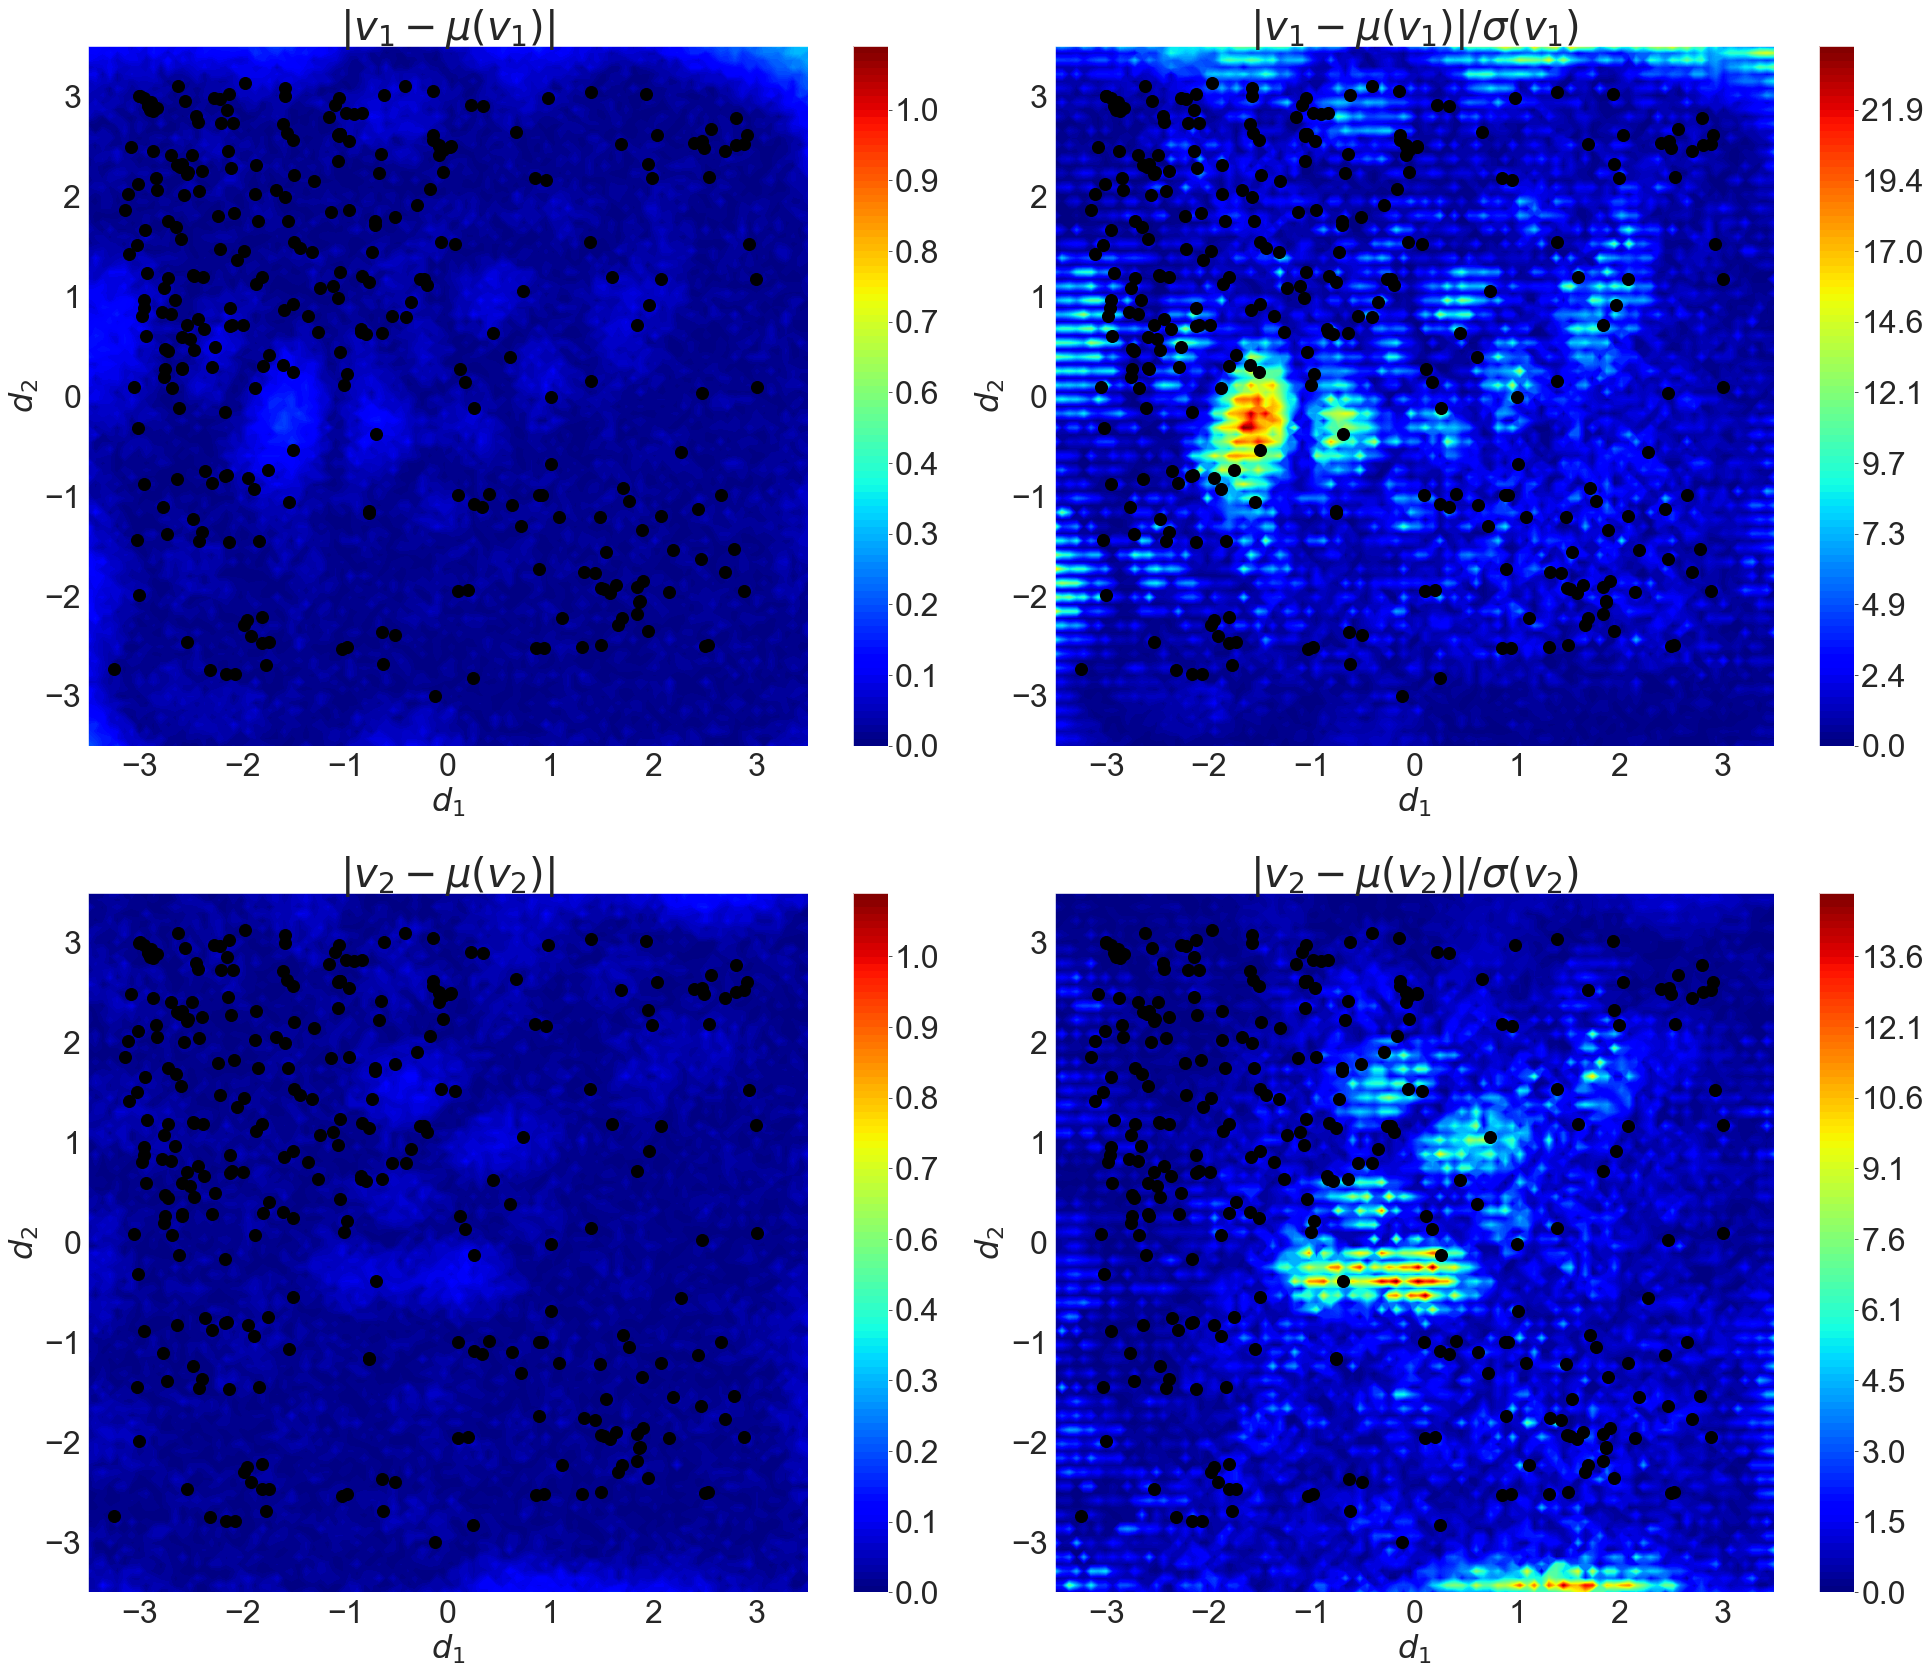

In [14]:
# f_target = vf.tgt_vec
# f_target = f_target.reshape(f_target.shape[0],1)
# vf.tgt_loc = vf.tgt_loc.reshape(2,1)
#x0 = Tensor(np.array([0.1937, 0.1257]))
#x0 = Tensor(np.array([0.1885, 0.1038]))
x_plot = np.linspace(-3.5, 3.5, 100)
y_plot = np.linspace(-3.5, 3.5, 100)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat_ = torch.zeros(n * n, 2)

# n_sample = x_concat_.shape[0]
num_tasks = 2
i = 0
k = 0
while i < n*n:
    x_concat_[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat_[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n
    

tgt_plot = vfield_(x_concat_)
agg_data = vfield_(Tensor(g_theta1))
agg_data = agg_data.flatten()

v_1 = tgt_plot[:,0].reshape(n,n)
v_2 = tgt_plot[:,1].reshape(n,n)

PATH = ".//model_Carlo/model_goodmodel/model_fail_"+str(75)+".pt"
model = torch.load(PATH)

model.eval()

#likelihood.eval()

#noise = torch.eye(2 * g_theta1.detach().shape[0]) * noise_value
#print(x_concat_)
with torch.no_grad(), gpytorch.settings.fast_pred_var(True):
    pred = GPprediction(model)
    pr_mean, cov = pred.GPpred(Tensor(g_theta1), agg_data, x_concat_, noise_value)
    #pr = (model(g_theta1.detach())) # likelihood(model(x_concat_), noise = torch.ones(x_concat_.shape) * noise_value)#
    pr_mean = pr_mean.reshape(x_concat_.shape[0], num_tasks)
    mean_v_1 = pr_mean[:,0].reshape(n,n)
    mean_v_2 = pr_mean[:,1].reshape(n,n)
    pred_var = cov.diag().reshape(num_tasks, x_concat_.shape[0]).T
    
    var_v_1 = pred_var[:,0].reshape(n,n)
    var_v_2 = pred_var[:,1].reshape(n,n)
#     AA = pr.covariance_matrix.mean(axis=0).reshape(num_tasks, x_concat_.shape[0]).T #.diag() #.reshape(num_tasks, num_tasks * g_theta1.shape[0]).T

# #     print(pr.covariance_matrix.mean(axis=0))
# #     print(AA)
# #     print(pr.variance)
# #     print((pr.covariance_matrix))
# #     K = model.covar_module
#     print((cov.diag()))
#     print(pr_mean)


fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (28, 24), tight_layout=True)
diff_mean_v1= torch.abs(v_1 - mean_v_1.detach())#/torch.abs(v_1)
cs10 = ax1[0].contourf(xv_plot, yv_plot,diff_mean_v1 ,np.linspace(0, 1.1, 100), cmap = 'jet')
#ax1[0].plot(0.8731, 0.5664, 'o', color = 'magenta', markersize=12)
ax1[0].plot(g_theta1[:, 0],g_theta1[:, 1] , 'o', color = 'black',markersize=12, alpha = 1.0)
ax1[0].set_title('$|v_1 - \mu(v_1)|$', fontsize = 40)
cbar10 = fig.colorbar(cs10, ax = ax1[0],format=OOMFormatter(0, mathText=False));

ax1[0].set_xlabel('$d_1$')
ax1[0].set_ylabel('$d_2$')
diff_mean_v1 = torch.abs(v_1 - mean_v_1.detach())/torch.sqrt(var_v_1)
#print(var_v_1)
cs11 = ax1[1].contourf(xv_plot, yv_plot,diff_mean_v1 ,np.linspace(diff_mean_v1.min(), diff_mean_v1.max(), 100), cmap = 'jet')
#ax1[1].plot(0.8731, 0.5664, 'o', color = 'magenta', markersize=12)
ax1[1].plot(g_theta1[:, 0],g_theta1[:, 1] , 'o', color = 'black',markersize=12, alpha = 1.0)
ax1[1].set_title('$|v_1 - \mu(v_1)|/\sigma(v_1)$', fontsize = 40)
# ax1[0].set_aspect('equal')
# ax1[1].set_aspect('equal')
cbar11 = fig.colorbar(cs11, ax = ax1[1],format=OOMFormatter(0, mathText=False));
ax1[1].set_xlabel('$d_1$')
ax1[1].set_ylabel('$d_2$')


diff_mean_v2= torch.abs(v_2 - mean_v_2.detach())
cs20 = ax2[0].contourf(xv_plot, yv_plot, diff_mean_v2,np.linspace(0, 1.1, 100), cmap = 'jet')
#ax2[0].plot(0.8731, 0.5664, 'o', color = 'magenta', markersize=12)
ax2[0].plot(g_theta1[:, 0],g_theta1[:, 1] , 'o', color = 'black',markersize=12, alpha = 1.0)
ax2[0].set_title('$|v_2 - \mu(v_2)|$', fontsize = 40)
cbar20 = fig.colorbar(cs20, ax = ax2[0],format=OOMFormatter(0, mathText=False));
ax2[0].set_xlabel('$d_1$')
ax2[0].set_ylabel('$d_2$')


diff_mean_v2= torch.abs(v_2 - mean_v_2.detach())/torch.sqrt(var_v_2)
cs21 = ax2[1].contourf(xv_plot, yv_plot, diff_mean_v2,np.linspace(diff_mean_v2.min(), diff_mean_v2.max(), 100), cmap = 'jet')
ax2[1].plot(g_theta1[:, 0],g_theta1[:, 1] , 'o', color = 'black',markersize=12, alpha = 1.0)
#ax2[1].plot(0.8731, 0.5664, 'o', color = 'magenta', markersize=12)
ax2[1].set_title('$|v_2 - \mu(v_2)|/\sigma(v_2)$', fontsize = 40)
cbar21 = fig.colorbar(cs21, ax = ax2[1],format=OOMFormatter(0, mathText=False));
ax2[1].set_xlabel('$d_1$')
ax2[1].set_ylabel('$d_2$')


# ax2[0].set_aspect('equal')
# ax2[1].set_aspect('equal')

plt.savefig('figures_Carlo/mean_var/mean_final_fail.pdf', dpi=300, bbox_inches='tight')
plt.show()




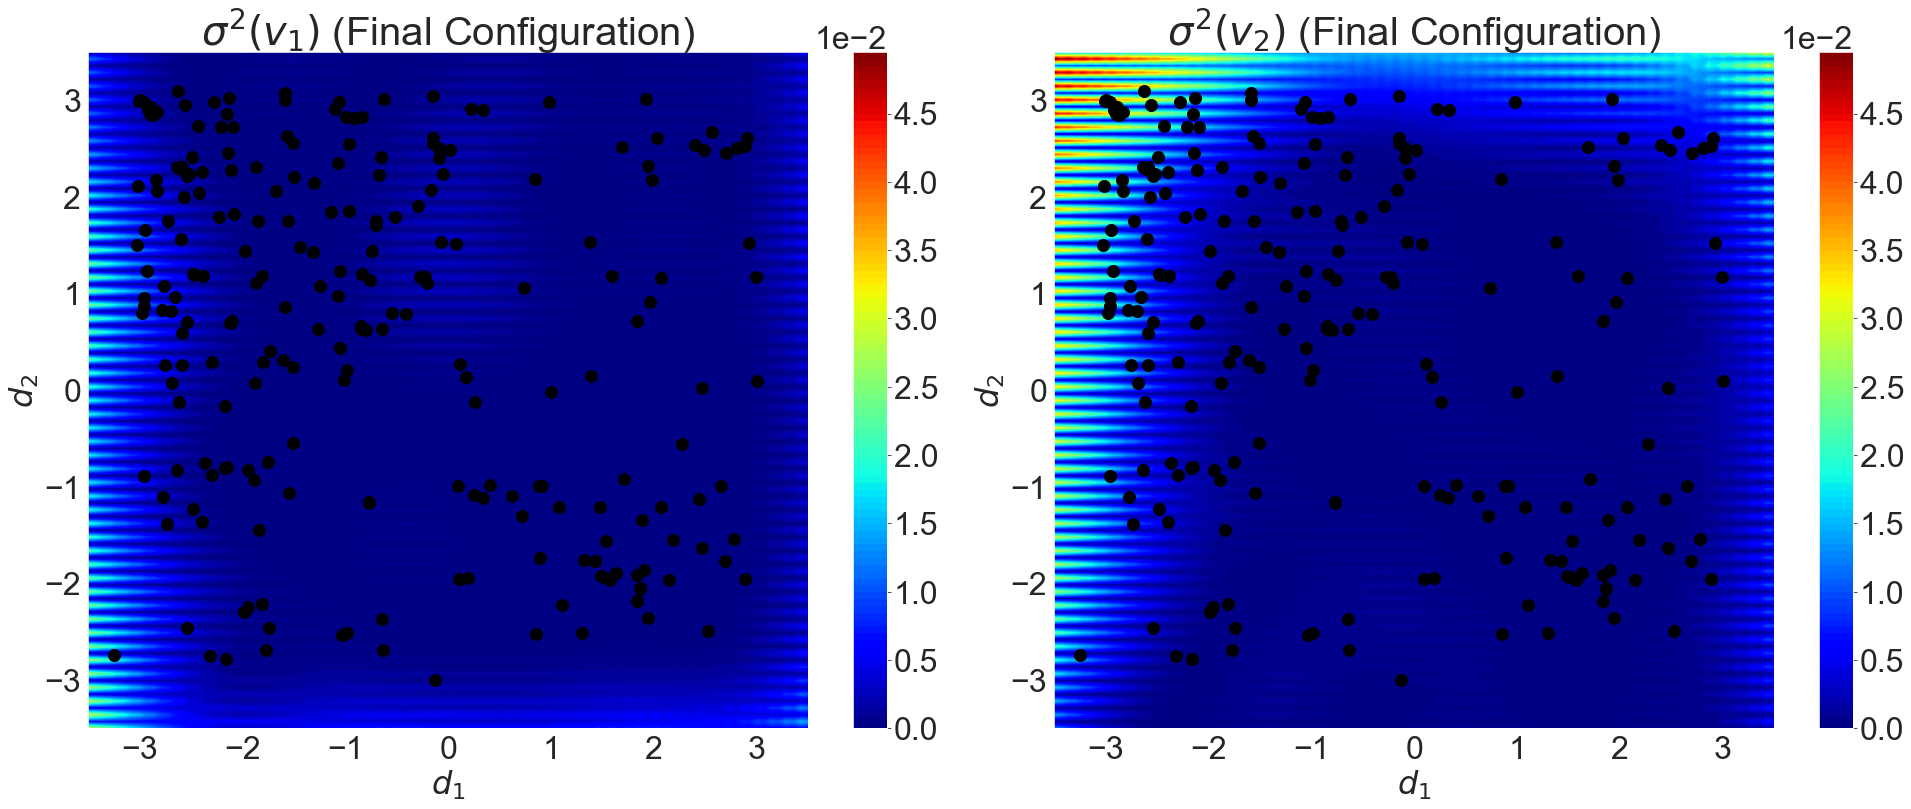

In [12]:
# f_target = vf.tgt_vec
# f_target = f_target.reshape(f_target.shape[0],1)
# vf.tgt_loc = vf.tgt_loc.reshape(2,1)
#x0 = Tensor(np.array([0.1937, 0.1257]))
#x0 = Tensor(np.array([0.1885, 0.1038]))
x_plot = np.linspace(-3.5, 3.5, 100)
y_plot = np.linspace(-3.5, 3.5, 100)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat_ = torch.zeros(n * n, 2)

# n_sample = x_concat_.shape[0]
num_tasks = 2
i = 0
k = 0
while i < n*n:
    x_concat_[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat_[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n
    

tgt_plot = vfield_(x_concat_)
agg_data = vfield_(Tensor(g_theta1))
agg_data = agg_data.flatten()


v_1 = tgt_plot[:,0].reshape(n,n)
v_2 = tgt_plot[:,1].reshape(n,n)
plot = [76]

for ii in plot:
    try:
        
        PATH = ".//model_Carlo/model_goodmodel/model_fail_"+str(ii - 1)+".pt"
        model_16 = torch.load(PATH)
    except:
        PATH = ".//model_Carlo/model_update/model_fail_"+str(ii - 1)+".pt"
        model_16 = torch.load(PATH)
        
    #model_16 = torch.load(PATH)
    model_16.eval()

#     likelihood.eval()

    #noise = torch.eye(2 * g_theta1.detach().shape[0]) * noise_value
    #print(x_concat_)
    with torch.no_grad(), gpytorch.settings.fast_pred_var(False):
        pred = GPprediction(model_16)
        pr_mean, cov = pred.GPpred(Tensor(g_theta1), agg_data, x_concat_, noise_value)
        #pr = (model(g_theta1.detach())) # likelihood(model(x_concat_), noise = torch.ones(x_concat_.shape) * noise_value)#
        pr_mean = pr_mean.reshape(x_concat_.shape[0], num_tasks)
        mean_v_1 = pr_mean[:,0].reshape(n,n)
        mean_v_2 = pr_mean[:,1].reshape(n,n)
        pred_var = cov.diag().reshape(num_tasks, x_concat_.shape[0]).T

        var_v_1 = pred_var[:,0].reshape(n,n)
        var_v_2 = pred_var[:,1].reshape(n,n)
    #     AA = pr.covariance_matrix.mean(axis=0).reshape(num_tasks, x_concat_.shape[0]).T #.diag() #.reshape(num_tasks, num_tasks * g_theta1.shape[0]).T

    # #     print(pr.covariance_matrix.mean(axis=0))
    # #     print(AA)
    # #     print(pr.variance)
    # #     print((pr.covariance_matrix))
    # #     K = model.covar_module
    #     print((cov.diag()))
    #     print(pr_mean)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (28, 12), tight_layout=True)
    diff_mean_v1= torch.abs(v_1 - mean_v_1.detach())#/torch.abs(v_1)
    minn = torch.min(var_v_1.detach().min(), var_v_2.detach().min())
    maxx = torch.min(var_v_1.detach().max(), var_v_2.detach().max())

    cs11 = ax1.contourf(xv_plot, yv_plot, var_v_1.detach(), np.linspace(0.0, .05, 100), cmap = 'jet')
   # ax1.plot(0.8731, 0.5664, 'o', color = 'magenta', markersize=12)
    
    ax1.plot(g_theta1[0:(4 + (ii - 1)* 3), 0],g_theta1[0:(4 + (ii - 1)* 3), 1] , 'o', color = 'black',markersize=12, alpha = 1.0)
  
    ax1.set_title('$\sigma^2(v_1)$ (Final Configuration)', fontsize = 40)
    # ax1[0].set_aspect('equal')
    # ax1[1].set_aspect('equal')
    cbar11 = fig.colorbar(cs11, ax = ax1,format=OOMFormatter(-2, mathText=False));
    ax1.set_xlabel('$d_1$')
    ax1.set_ylabel('$d_2$')


  


    cs21 = ax2.contourf(xv_plot, yv_plot, var_v_2.detach(), np.linspace(0.0, .05, 100), cmap = 'jet')
    ax2.plot(g_theta1[0:(4 + (ii - 1)* 3), 0],g_theta1[0:(4 + (ii - 1)* 3), 1] , 'o', color = 'black',markersize=12, alpha = 1.0)
   # ax2.plot(0.8731, 0.5664, 'o', color = 'magenta', markersize=12)
    ax2.set_title('$\sigma^2(v_2)$ (Final Configuration)', fontsize = 40)
    cbar21 = fig.colorbar(cs21, ax = ax2,format=OOMFormatter(-2, mathText=False));
    ax2.set_xlabel('$d_1$')
    ax2.set_ylabel('$d_2$')


    # ax2[0].set_aspect('equal')
    # ax2[1].set_aspect('equal')

    plt.savefig('figures_Carlo/mean_var/var_iter_fail'+str(ii)+'.pdf', dpi=300, bbox_inches='tight')
    plt.show()





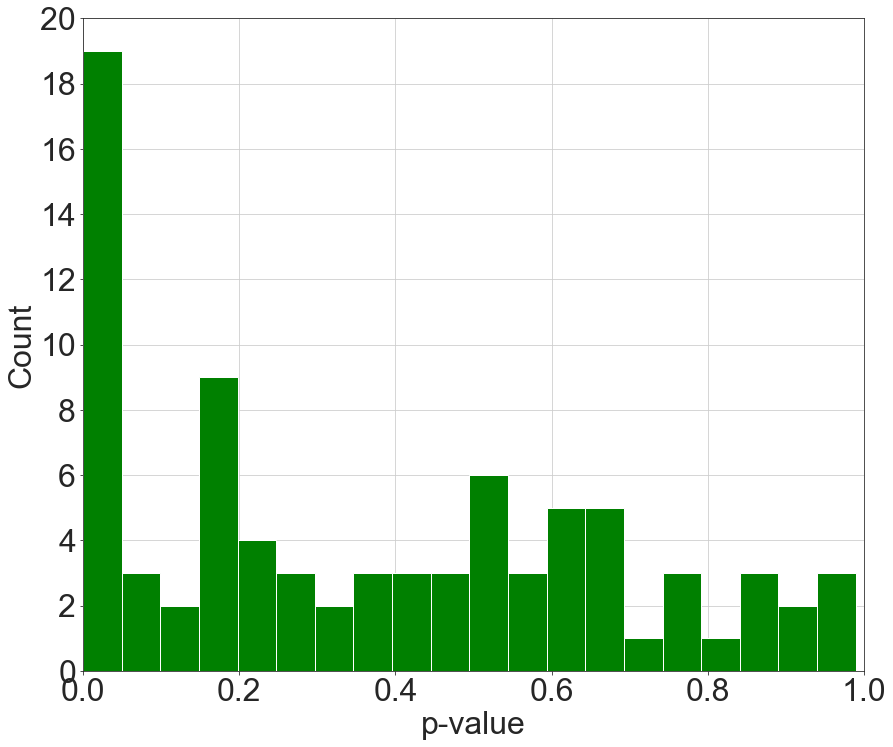

In [67]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize = (14,12))

data= scipy.io.loadmat('data_plots/p_vec_fail.mat')
p_fail = data['p_vec_fail']
count, bins, ignored = ax.hist(p_fail, 20, facecolor='green') 

ax.set_xlabel('p-value')
ax.set_ylabel('Count')
#plt.title("Uniform Distribution Histogram (Bin size 20)")
ax.set_xlim(0, 1)
ax.set_ylim(0, 20)
plt.xticks(np.arange(0, 1.2, step=.2))
plt.yticks(np.arange(0, 21, step=2.))
#ax.set_axis([0, 1, 0, 20]) # x_start, x_end, y_start, y_end
ax.grid(True)


plt.savefig('figures_Carlo/p_value_fail_hist.pdf', dpi=300, bbox_inches='tight')
plt.show(block = False)

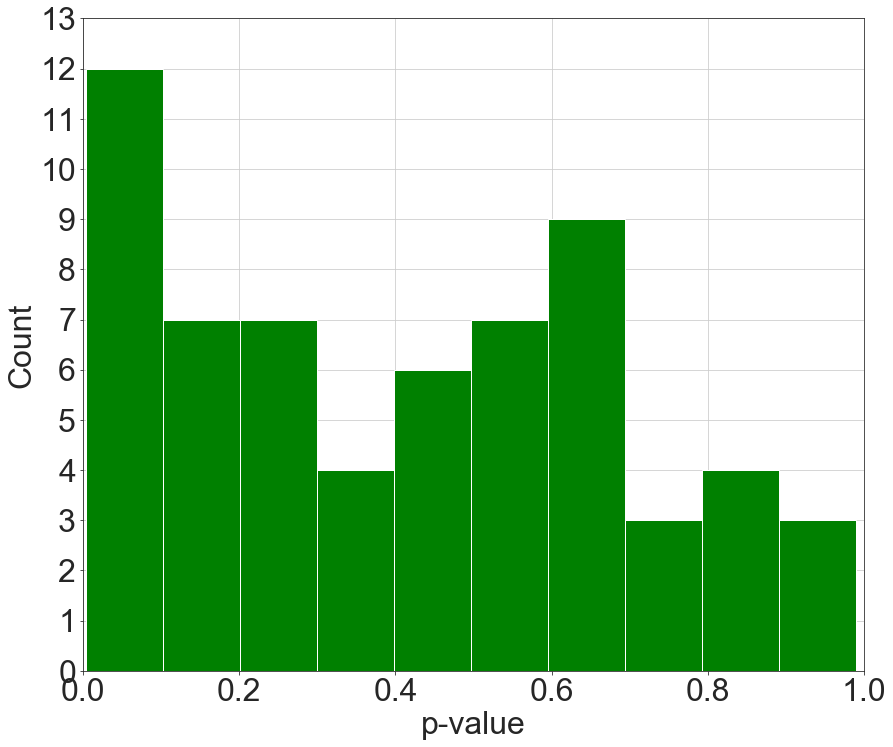

In [68]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize = (14,12))

data= scipy.io.loadmat('data_plots/p_vec_fail.mat')
p_fail = data['p_vec_fail']
p_fail_20 = p_fail[21:]
count, bins, ignored = ax.hist(p_fail_20, 10, facecolor='green') 

ax.set_xlabel('p-value')
ax.set_ylabel('Count')
#plt.title("Uniform Distribution Histogram (Bin size 20)")
ax.set_xlim(0, 1)
ax.set_ylim(0, 13)
plt.xticks(np.arange(0, 1.2, step=.2))
plt.yticks(np.arange(0, 14, step=1.))
#ax.set_axis([0, 1, 0, 20]) # x_start, x_end, y_start, y_end
ax.grid(True)


plt.savefig('figures_Carlo/p_value_fail_hist_from_iter_20.pdf', dpi=300, bbox_inches='tight')
plt.show(block = False)

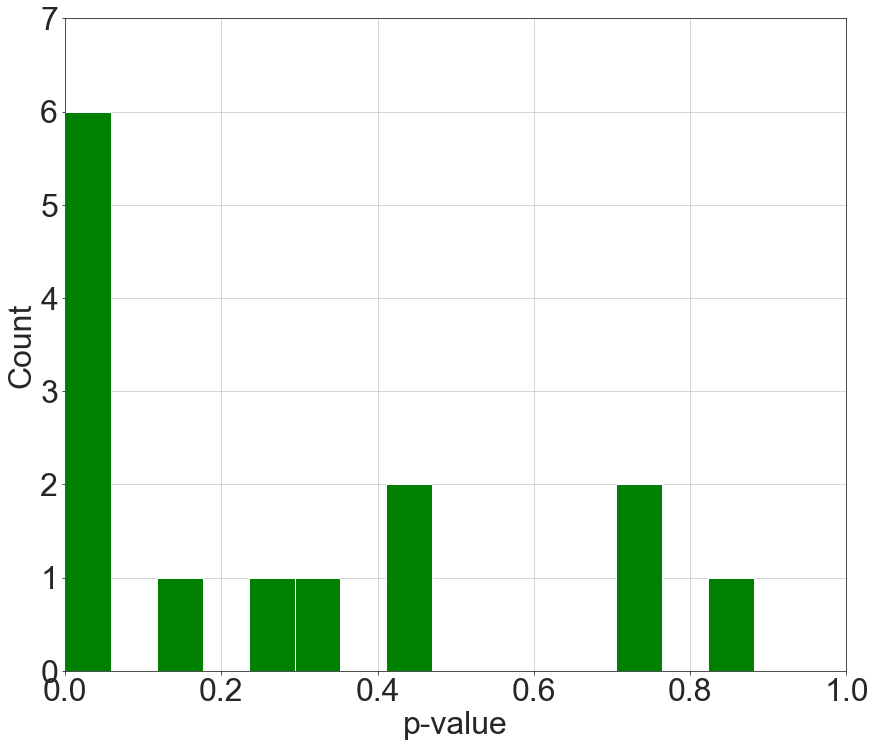

In [73]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize = (14,12))

data= scipy.io.loadmat('data_plots/p_vec_success.mat')
p_success = data['p_vec_success']
#p_success = p_success[4:]
count, bins, ignored = ax.hist(p_success, 15, facecolor='green') 

ax.set_xlabel('p-value')
ax.set_ylabel('Count')
#plt.title("Uniform Distribution Histogram (Bin size 20)")
ax.set_xlim(0, 1)
ax.set_ylim(0, 3)
plt.xticks(np.arange(0, 1.2, step=.2))
plt.yticks(np.arange(0, 8, step=1.))
#ax.set_axis([0, 1, 0, 20]) # x_start, x_end, y_start, y_end
ax.grid(True)


plt.savefig('figures_Carlo/p_value_success_hist.pdf', dpi=300, bbox_inches='tight')
plt.show(block = False)

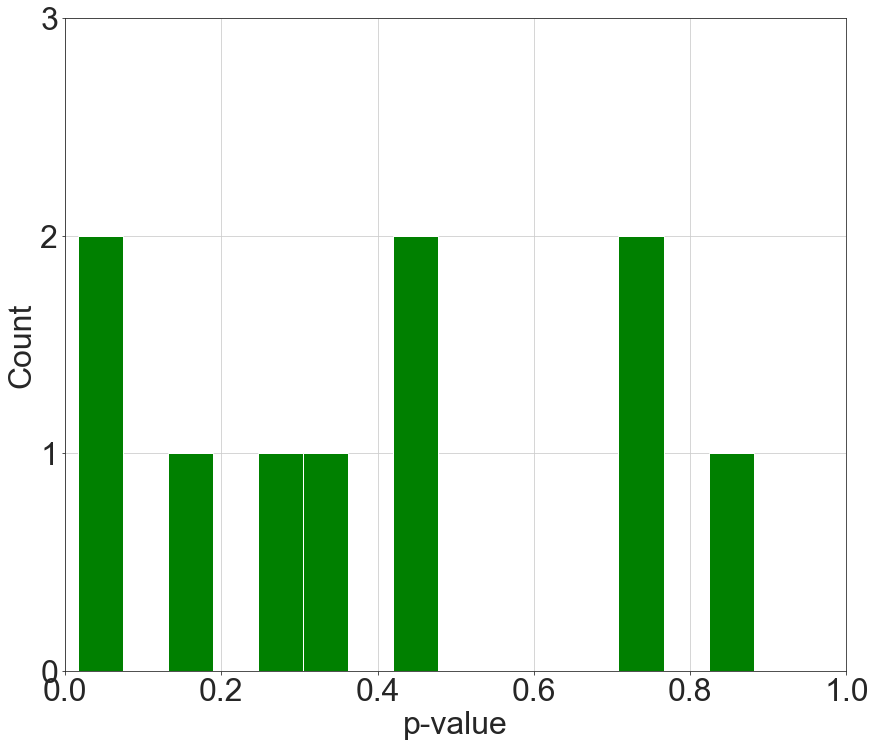

In [74]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize = (14,12))

data= scipy.io.loadmat('data_plots/p_vec_success.mat')
p_success = data['p_vec_success']
p_success = p_success[4:]
count, bins, ignored = ax.hist(p_success, 15, facecolor='green') 

ax.set_xlabel('p-value')
ax.set_ylabel('Count')
#plt.title("Uniform Distribution Histogram (Bin size 20)")
ax.set_xlim(0, 1)
ax.set_ylim(0, 3)
plt.xticks(np.arange(0, 1.2, step=.2))
plt.yticks(np.arange(0, 4, step=1.))
#ax.set_axis([0, 1, 0, 20]) # x_start, x_end, y_start, y_end
ax.grid(True)


plt.savefig('figures_Carlo/p_value_success_hist_from_4.pdf', dpi=300, bbox_inches='tight')
plt.show(block = False)

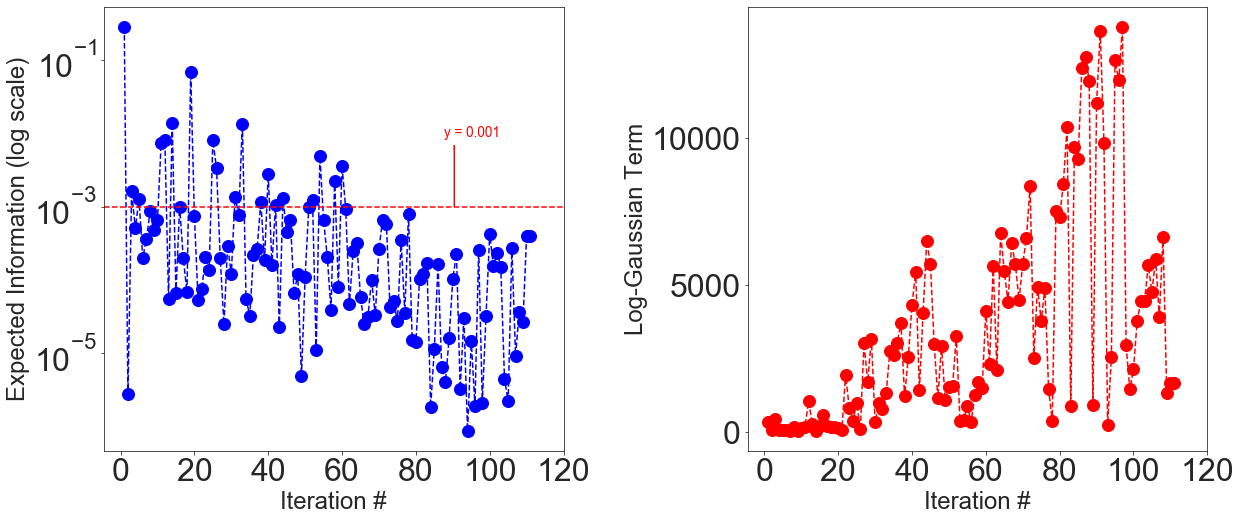

In [40]:
sns.set_style('ticks')
iter = 110
data= scipy.io.loadmat('data_plots/entropy_vec_fail.mat')
entropy_vec_plot = data['entropy_vec_fail']

data= scipy.io.loadmat('data_plots/loggauss_vec_fail.mat')
data_fit_vec_plot = data['loggauss_vec_fail']
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 8), tight_layout=True)

ax1.plot(np.array(range(1,iter+2)), (entropy_vec_plot), '--o', color = 'blue', markersize=12)
ax1.axhline(.001,linestyle = '--',color = 'red', markersize=12, alpha = 1.0)

ax1.annotate('y = 0.001', xy=(0.55, 0.15), xytext=(0.8, 0.7), xycoords='axes fraction', 
            fontsize=9*1.5, color = 'red', ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax1.arrow(90.4,        #x start point
             0.001,                      #y start point
             0,       #change in x 
             0.005,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.003,        #arrow head length
             width=0.1,              #arrow stem width
             fc='red',             #arrow fill color
             ec='red') 

#ax1.set_yscale('log')
# ax.plot(np.array(data_fit_vec_plot), (entropy_vec_plot), 'o')
ax1.set_yscale('log')

ax2.plot(np.array(range(1,iter+2)), data_fit_vec_plot, '--o', color = 'red', markersize=12)

ax1.set_xlabel('Iteration #', size=24)
ax2.set_xlabel('Iteration #', size=24)
ax1.set_xticks(np.arange(0,iter+15, step=20.))
ax1.set_ylabel('Expected Information (log scale)', size = 24)
ax2.set_ylabel('Log-Gaussian Term', size = 24)
ax2.set_xticks(np.arange(0,iter+15, step=20.))
#ax2.yfmt.set_useOffset(10000)

plt.savefig('figures_Carlo/expectedinfo_vs_datafit_fail_EIbehavior.pdf',dpi=300, bbox_inches='tight')
plt.show()